In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion
import re
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, confusion_matrix, precision_recall_curve, roc_curve, f1_score, accuracy_score
from sklearn.preprocessing import label_binarize
import os
import gzip
import random
from matplotlib import pyplot as plt
from sklearn.pipeline import make_pipeline
import pickle
import seaborn as sns
import scikitplot as skplt
import time
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torch.utils.data as td
from tqdm.autonotebook import tqdm, trange
import inspect
import warnings
warnings.filterwarnings('ignore')

/anaconda3/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
# Returns a string of length bytes long

def dataloader(filepath, length):
    f = gzip.GzipFile(fileobj=open(filepath, 'rb'))
    data = f.read(length)
    return data.decode("utf-8")

In [3]:
# Returns dataframe of # of files long. Analyze the first length bytes of each file

def trainloader(direclist, filetype, length):
    fileid = np.arange(len(filetype))
    dat = []
    filelabels = []
    c = -1
    for direc in direclist:
        c+=1
        for file in os.listdir(direc):
            if file.endswith('fna.gz'):
                tempdat = dataloader(os.path.join(direc,file),length)
                dat = dat + [tempdat]
                filelabels.append(0)
            if file.endswith('fna.trunc'):
                tfile = open(os.path.join(direc,file), 'rb')
                tempdat = tfile.read(length).decode("utf-8")
                dat = dat + [tempdat]
                filelabels.append(0)
                
            if file.endswith('gbff.gz'):
                tempdat = dataloader(os.path.join(direc,file),length)
                dat = dat + [tempdat]
                filelabels.append(1)
            if file.endswith('gbff.trunc'):
                tfile = open(os.path.join(direc,file), 'rb')
                tempdat = tfile.read(length).decode("utf-8")
                dat = dat + [tempdat]
                filelabels.append(1)
                
            if file.endswith('gff.gz'):
                tempdat = dataloader(os.path.join(direc,file),length)
                dat = dat + [tempdat]
                filelabels.append(2)
            if file.endswith('gff.trunc'):
                tfile = open(os.path.join(direc,file), 'rb')
                tempdat = tfile.read(length).decode("utf-8")
                dat = dat + [tempdat]
                filelabels.append(2)
                
            if file.endswith('fastq.truncated'):
                tfile = open(os.path.join(direc,file), 'rb')
                tempdat = tfile.read(length).decode("utf-8")
                dat = dat + [tempdat]
                filelabels.append(3)
            if file.endswith('sra.truncated'):
                tfile = open(os.path.join(direc,file), 'rb')
                tempdat = tfile.read(length).decode("ISO-8859-1")
                dat = dat + [tempdat]
                filelabels.append(4)
                
    data = {'Data': dat,
        'Type': filelabels
    }
    df = pd.DataFrame(data, columns = ['Data', 'Type'])
    return(df)

In [4]:
# Returns rows of correctly classified features

def rowextraction(predicted, truth):
    return([np.where(predicted==truth)[0], np.where(predicted!=truth)[0]])

In [5]:
# Returns distribution of probability of class being correct for correctly classified features

def uncertainty(pred, row_ind, num_classes):
    class_arr = [[] for i in range(num_classes)]
    dist_arr = []
    for ind in row_ind:
        class_ind = np.argmax(pred[ind])
        class_arr[class_ind].append(np.max(pred[ind]))
    for arr in class_arr:
        dist_arr.append([np.mean(arr),np.std(arr)])
    return(dist_arr)

In [6]:
# Returns Graphs of Feature Importance by Importance Type

def FeatureImportance(model, features, importance):
    for im in importance:
        feature_important = model.get_score(importance_type = im)
        keys = list(feature_important.keys())
        feature_chars = []
        keylist = []
        for key in keys:
            keylist.append(int(key.replace('f','')))
        for i in keylist:
            feature_chars.append(features[i])
        values = list(feature_important.values())
        fdata = pd.DataFrame(data=values, index=feature_chars, columns=["score"]).sort_values(by = "score", ascending=False)
        fdata.plot(kind='barh', title = im)    
        
    

In [7]:
# Prints Confusion Matrix

def confusionmatrix(truth, pred, names, thresh, classifier):
    cm = confusion_matrix(truth, pred)
    plt.figure()
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.colorbar().set_label("# Classified")
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.title("Confusion Matrix")
    plt.savefig(classifier+"ConfusionMatrix{}.pdf".format(thresh))
    plt.show()

In [8]:
# Returns Accuracy Per Class

def classaccuracy(truth, pred, ind, num_classes):
    classes = np.arange(num_classes)
    predcl = np.asarray([np.argmax(pred[i]) for i in ind])
    acc = []
    for cl in classes:
        truth_len = len(np.where(truth == cl)[0])
        pred_len = len(np.where(predcl == cl)[0])
        acc.append(pred_len/truth_len)
    return(acc)

In [9]:
#Splits our data into train/test

def Data_Splitter(Dataset, ttsplit):
    X = Dataset.iloc[:,0]
    y = Dataset.iloc[:,1]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ttsplit , stratify = y, random_state = 42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=ttsplit , stratify = y_train, random_state = 42)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [10]:
# Tf-idf Transformation on Training and Validation data based on max_features # of vocabulary words
# generated from each file class.

def Char_vectorizer2(X_train, y_train, X_test, y_test, filetype, ngram_range, max_features, load):
    
    fitset = trainselector2(np.array(X_train), np.array(y_train), len(filetype))
    
    if load == False:
        start = time.time()
        print("Generating Character Vectorizer...")
        char_vocab = {}
        for fileset in fitset:
            char_vectorizer = TfidfVectorizer(analyzer = 'char',
                ngram_range = ngram_range, max_features = max_features)
            char_vectorizer.fit(fileset)
            char_vocab.update(char_vectorizer.vocabulary_)
            
        count = -1
        for key in char_vocab.keys():
            count+=1
            char_vocab[key] = count
            
    
        char_vectorizer2 = TfidfVectorizer(analyzer = 'char',
                ngram_range = ngram_range, max_features = max_features,
                                vocabulary = char_vocab)
        char_vectorizer2.fit(X_train)
        print(char_vectorizer2.get_feature_names())
        
        train_chars = char_vectorizer2.transform(X_train)
        test_chars = char_vectorizer2.transform(X_test)
        pickle.dump(char_vectorizer2, open("tfidfcv2.pkl", "wb"))
        print("Character Vectorizer Saved")
        end = time.time()
        print("Vectorizer Train Time: %d" % (end-start))
        
    if load == True:
        start = time.time()
        print("Loading Character Vectorizer...")
        char_vectorizer = pickle.load(open("tfidfcv2.pkl", 'rb'))
        print("Character Vectorizer Loaded")
    
        print(char_vectorizer.get_feature_names())
        train_chars = char_vectorizer.transform(X_train)
        test_chars = char_vectorizer.transform(X_test)
        end = time.time()
        print("Vectorizer Load Time: %d" % (end-start))
    
    
    
    return train_chars, test_chars

In [11]:
# Prints amount of files per class and percentage representation of each class per set

def classcounts(y_set, nclass, filetypes):
    setnames = ['Train', 'Validation', 'Test']
    ind = -1
    print("Filetype Location: {}".format(filetypes))
    for y in y_set:
        ind+=1
        y = np.asarray(y)
        counts = [[] for i in range(nclass)]
        percs = [[] for i in range(nclass)]
        labels = np.arange(nclass)
        for c in range(nclass):
            local = len(np.where(y == c)[0])
            counts[c] = local
            percs[c] = round((local/len(y)),4)
        print(setnames[ind] + ' counts: {}'.format(counts))
        print(setnames[ind] + ' percentages: {}'.format(percs))
        


In [12]:
# Vectorizes test set and converts to DMatrix

def test_char_vectorizer(X_test):
    start = time.time()
    #print("Loading Character Vectorizer...")
    char_vectorizer = pickle.load(open("tfidfcv2.pkl", 'rb'))
    #print("Character Vectorizer Loaded")
    #print(char_vectorizer.get_feature_names())
    
    test_chars = char_vectorizer.transform(X_test)
    
    #dtest = xgb.DMatrix(test_chars)
    end = time.time()
    #print("Vectorizer Load Time: %d" % (end-start))
    
    return test_chars

In [13]:
# Timing Simulation for 1 file

def FileVecTime(X_test, Vectorizer, nsims, nfile, model):
    Onefiletimes = []
    nsims = 1000
    for i in range(nsims):
        r = np.random.randint(len(X_test))
        localtest = X_test.iloc[r]
        Start_t = time.time()
        vectest = Vectorizer([localtest])
        data_test = xgb.DMatrix(vectest)
        pred = model.predict(data_test)
        End_t = time.time()
        
        Onefiletimes.append(End_t-Start_t)
    
    return(np.mean(Onefiletimes), np.std(Onefiletimes))
        
        
        
        

In [14]:
# Splits our training data into parts by filetype

def trainselector2(train_data, train_label, n_class):
    labelmat = [[] for i in range(n_class)]
    
    for c in range(n_class):
        t_labelloc = np.where(train_label == c)[0]
        labelmat[c].extend(train_data[t_labelloc])
    
    return(labelmat)
        

In [15]:
# Trains/Loads XGB Classifier

def TrainXGBClassifier(param, num_round, train_dat, val_dat, y_train, y_val, load):
    train_dat = xgb.DMatrix(train_dat, label = y_train)
    val_dat = xgb.DMatrix(val_dat, label = y_val)
    if load == False:
        start = time.time()
        print("Training Model...")
        model = xgb.train(param, train_dat, num_round, evals = [(train_dat, 'train'), (val_dat, 'eval')], verbose_eval = True)
        pickle.dump(model, open("xgb_class.pkl", "wb"))
        print("Model Saved")
        end = time.time()
        print('Training time: %d' % (end-start))
    if load == True:
        print("Loading Model...")
        model = pickle.load(open("xgb_class.pkl", "rb"))
        print("Model Loaded")
        
    return model

In [16]:
# Trains/Loads SVM Classifier

def TrainSVMClassifier(train_dat, y_train, load):
    if load == False:
        start = time.time()
        print("Training Model...")
        model = OneVsRestClassifier(SVC(kernel='linear', probability=True, C=1))
        model.fit(train_dat, y_train)
        pickle.dump(model, open("svm_class.pkl", "wb"))
        print("Model Saved")
        end = time.time()
        print('Training time: %d' % (end-start))
    if load == True:
        print("Loading Model...")
        model = pickle.load(open("svm_class.pkl", "rb"))
        print("Model Loaded")
        
    return model

In [17]:
# File Classification Multilayer Perceptron

class FileNet(nn.Module):
    def __init__(self):
        super(FileNet, self).__init__()
        self.fc1 = nn.Linear(60, 90)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(90, 120)
        self.fc3 = nn.Linear(120, 60)
        self.fc4 = nn.Linear(60, 5)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = F.dropout(x, p = 0.3, training = True)
        x = self.fc2(x)
        x = self.relu(x)
        x = F.dropout(x, p = 0.3, training = True)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = F.softmax(x, dim = 1)
        
        return x

In [18]:
# Metric Calculation and Visualization for MLP Source: https://github.com/marrrcin/pytorch-resnet-mnist

def calculate_metric(metric_fn, true_y, pred_y):
    if "average" in inspect.getfullargspec(metric_fn).args:
        return metric_fn(true_y, pred_y, average="macro")
    else:
        return metric_fn(true_y, pred_y)
    
def print_scores(p, r, f1, a, batch_size):
    for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p, r, f1, a)):
        print(f"\t{name.rjust(14, ' ')}: {sum(scores)/batch_size:.4f}")

In [19]:
# Trains/Loads MLP Classifier

def TrainMLPClassifier(Net, train_dat, y_train, val_dat, y_val, epochs, load):
    y_train = np.asarray(y_train)
    y_val = np.asarray(y_val)
    
    train_x = torch.Tensor(train_dat.toarray())
    train_y = torch.Tensor(y_train).long()
    train_ds = utils.TensorDataset(train_x,train_y)
    train_loader = td.DataLoader(train_ds, batch_size=10,
        shuffle=False, num_workers=1)

    val_x = torch.Tensor(val_dat.toarray())
    val_y = torch.Tensor(y_val).long()
    val_ds = utils.TensorDataset(val_x,val_y)
    val_loader = td.DataLoader(val_ds, batch_size=10,
        shuffle=False, num_workers=1)
    print("Loaders ready")
    
    if load == False:
        batches = len(train_loader)
        val_batches = len(val_loader)
        model = Net()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
        loss_criteria = nn.CrossEntropyLoss()
        start = time.time()
        print("Training Model...")
        for epoch in range(epochs):
            total_loss = 0
            progress = tqdm(enumerate(train_loader), desc = "Loss: ", total = batches)
            model.train()
            for batch, tensor in progress:
                data, target = tensor
                optimizer.zero_grad()
                out = model(data)
                loss = loss_criteria(out, target)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                progress.set_description("Loss: {:.4f}".format(total_loss/(batch+1)))
                
            val_losses = 0
            precision, recall, f1, accuracy = [], [], [], []

            model.eval()
            with torch.no_grad():
                for i, data in enumerate(val_loader):
                    X, y = data
                    outputs = model(X)

                    val_loss = loss_criteria(outputs, y)
                    val_losses += val_loss.item()

                    predicted_classes = torch.max(outputs.data, 1)[1]

                    for acc, metric in zip((precision, recall, f1, accuracy), 
                                           (precision_score, recall_score, f1_score, accuracy_score)):
                        acc.append(
                            calculate_metric(metric, y, predicted_classes)
                        )


            print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
            print_scores(precision, recall, f1, accuracy, val_batches)
            #losses.append(total_loss/batches)
        
        torch.save(model.state_dict(), 'FileClassMLP.pt')
        print("Model Saved")
        end = time.time()
        print('Training time: %d' % (end-start))
        
    if load == True:
        print("Loading Model...")
        model = Net()
        model.load_state_dict(torch.load('FileClassMLP.pt'))
        print("Model Loaded")
        
    return model
        

In [34]:
# Tests Classifier

def TestFileClassifier(model, data_test, filetype, y_test, output, threshold, threshold_plots, classifier):
      
    global_precision = []
    global_recall = []
    global_F1 = []
    global_class = [[] for c in range(len(filetype))]
    global_retain = []
    
    if classifier == 'xgb':
        data_test = xgb.DMatrix(data_test)
    if classifier == 'mlp':
        data_test = torch.Tensor(data_test.toarray())
    
    for thperc in threshold:
        y_test = np.asarray(y_test)
        
        y_test_threshold = []
        preds_threshold = []
        start = time.time()
        if classifier == 'xgb':
            preds = model.predict(data_test)
        if classifier == 'svm':
            preds = model.predict_proba(data_test)
        if classifier == 'mlp':
            model.eval()
            with torch.no_grad():
                preds = model(data_test).data.numpy()
        end = time.time()
        
        best_preds = []
        belowthresh = 0
        below_ind = []
        count = -1
        for p in range(len(y_test)):
            if np.max(preds[p]) < thperc:
                belowthresh += 1
     
                below_ind.append(p)
                
            else:
                y_test_threshold.append(y_test[p])
                preds_threshold.append(preds[p])
                best_preds.append(np.argmax([preds[p]]))
        
        best_preds = np.array(best_preds)
        y_test_threshold = np.array(y_test_threshold)
        new_preds = np.delete(preds, below_ind,0)
        
        local_retain = len(best_preds)/len(y_test)
        global_retain.append(local_retain)
        
        local_precision = precision_score(y_test_threshold, best_preds, average='macro')
        local_recall = recall_score(y_test_threshold, best_preds, average = 'macro')
        local_F1 = 2*(local_precision*local_recall)/(local_precision + local_recall)
        global_precision.append(local_precision)
        global_recall.append(local_recall)
        global_F1.append(local_F1)
        
        Y_bin = label_binarize(y_test_threshold, classes = [*range(len(filetype))])
        curr_thresh = thperc
        if output == True:
            prec = dict()
            rec = dict()
            for f in range(len(filetype)):
                prec[f],rec[f],_ = precision_recall_curve(Y_bin[:,f], new_preds[:,f])
                plt.plot(rec[f], prec[f], lw = 2, label = 'class '+filetype[f])
            plt.xlabel("Recall")
            plt.ylabel("Precision")
            plt.legend(loc="best")
            plt.ylim([0.8,1])
            #plt.title("Precision vs. Recall Curve for Threshold: {}".format(curr_thresh))
            plt.savefig(classifier+"PRCThreshold{}.pdf".format(curr_thresh))
            #plt.figure(figsize = (20,10))
            plt.show()


            fpr = dict()
            tpr = dict()
            for e in range(len(filetype)):
                fpr[e], tpr[e], _ = roc_curve(Y_bin[:, e],
                                              new_preds[:, e])
                plt.plot(fpr[e], tpr[e], lw=2, label='class '+filetype[e])

            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.legend(loc="best")
            plt.ylim([0.8,1])
            #plt.title("ROC Curve for Threshold: {}".format(curr_thresh))
            plt.savefig(classifier+"ROCThreshold{}.pdf".format(curr_thresh))
            plt.show()

        
        if output == True:
            print('Testing time: %d' % (end-start))
            
            if classifier == 'xgb':
                char_vectorizer = pickle.load(open("tfidfcv2.pkl", 'rb'))
                FeatureImportance(model, char_vectorizer.get_feature_names(), ['weight','cover','gain'])
            
            print("Precision: {}".format(local_precision))
            print("Recall: {}".format(local_recall))
            print("F1: {}".format(local_F1))
            
            y_test_arr = np.asarray(y_test_threshold).reshape(1,-1).squeeze()
            correct_rows = rowextraction(best_preds,y_test_arr)[0]
            incorrect_rows = rowextraction(best_preds,y_test_arr)[1]
            class_acc = classaccuracy(y_test_arr, preds_threshold, correct_rows, len(filetype))
            pred_uncertainty = uncertainty(preds, correct_rows, len(filetype))
            for i in range(len(filetype)):
                global_class[i].append(round(class_acc[i],2))
                
            for i in range(param['num_class']):
                print("Class {}".format(filetype[i]) + " mean and sd: {}".format(pred_uncertainty[i])
                     + ", Accuracy: {}".format(round(class_acc[i],2)))
            confusionmatrix(y_test_arr, best_preds, filetype, curr_thresh, classifier)
            skplt.metrics.plot_roc(y_test_arr, new_preds)
            plt.ylim([0.5,1])
            plt.savefig(classifier+"ROCThreshold{}.pdf".format(curr_thresh))
            plt.show()

    if threshold_plots == True:
        fig, ax = plt.subplots()

        ax.plot(threshold, global_precision)
        ax.set(xlabel = '% Confidence Threshold', ylabel = 'Precision', title = 'Threshold vs Precision')
        ax.set_ylim([0.8,1])
        ax.set_xlim([0,0.8])
        ax.grid()
        #plt.figure(figsize = (20,10))
        plt.savefig(classifier+"ConfPrecThreshold{}.pdf".format(curr_thresh))

        plt.show()
        
        fig, ax = plt.subplots()

        ax.plot(threshold, global_recall)
        ax.set(xlabel = '% Confidence Threshold', ylabel = 'Recall', title = 'Threshold vs Recall')
        ax.set_ylim([0.8,1])
        ax.set_xlim([0,0.8])
        ax.grid()
        #plt.figure(figsize = (20,10))
        plt.savefig(classifier+"ConfRecallThreshold{}.pdf".format(curr_thresh))

        plt.show()
        
        fig, ax = plt.subplots()

        ax.plot(threshold, global_F1)
        ax.set(xlabel = '% Confidence Threshold', ylabel = 'F1')
        ax.set_ylim([0.8,1])
        ax.set_xlim([0,0.8])
        ax.grid()
        #plt.figure(figsize = (20,10))
        plt.savefig(classifier+"ConfF1Threshold{}.pdf".format(curr_thresh))

        plt.show()
        
        fig, ax = plt.subplots()

        ax.plot(threshold, global_retain, linewidth = 2)
        ax.set(xlabel = '% Confidence Threshold', ylabel = '% Retained')
        ax.set_ylim([0.8,1])
        ax.set_xlim([0,0.8])
        ax.grid()
        #plt.figure(figsize = (20,10))
        plt.savefig(classifier+"ConfRetainThreshold{}.pdf".format(curr_thresh))

        plt.show()
        
        
        
    if threshold_plots == True and output == True:
        for cl in range(len(filetype)):
            figc, axc = plt.subplots()
            axc.plot(threshold, global_class[cl])
            axc.set(xlabel = '% Confidence Threshold', ylabel = filetype[cl] + ' accuracy', title = 'Threshold vs ' + filetype[cl])
            axc.grid()
            #plt.figure(figsize = (20,10))
            plt.savefig(classifier+"ConfAccThreshold{}.pdf".format(curr_thresh))

            plt.show()

  
    return best_preds

In [21]:
def TestFileClassifier2(model, data_test, threshold, classifier):
    
    if classifier == 'xgb':
        data_test = xgb.DMatrix(data_test)
    if classifier == 'mlp':
        data_test = torch.Tensor(data_test.toarray())
    
    for thperc in threshold:
        preds_threshold = []
        start = time.time()
        if classifier == 'xgb':
            preds = model.predict(data_test)
        if classifier == 'svm':
            preds = model.predict_proba(data_test)
        if classifier == 'mlp':
            model.eval()
            with torch.no_grad():
                preds = model(data_test).data.numpy()
        end = time.time()
        
        best_preds = []
        below_ind = []

        for p in range(len(preds)):
            if np.max(preds[p]) < thperc:
                below_ind.append(p)
                
            else:
                preds_threshold.append(preds[p])
                best_preds.append(np.argmax([preds[p]]))
        
        best_preds = np.array(best_preds)

  
    return best_preds

In [22]:
def TestFileClassifier3(model, data_test, y_test, threshold, classifier):
    
    if classifier == 'xgb':
        data_test = xgb.DMatrix(data_test)
    if classifier == 'mlp':
        data_test = torch.Tensor(data_test.toarray())
    
    for thperc in threshold:
        y_test = np.asarray(y_test)
        
        y_test_threshold = []
        preds_threshold = []
        start = time.time()
        if classifier == 'xgb':
            preds = model.predict(data_test)
        if classifier == 'svm':
            preds = model.predict_proba(data_test)
        if classifier == 'mlp':
            model.eval()
            with torch.no_grad():
                preds = model(data_test).data.numpy()
        end = time.time()
        
        best_preds = []
        belowthresh = 0
        below_ind = []
        count = -1
        for p in range(len(y_test)):
            if np.max(preds[p]) < thperc:
                belowthresh += 1
     
                below_ind.append(p)
                
            else:
                y_test_threshold.append(y_test[p])
                preds_threshold.append(preds[p])
                best_preds.append(np.argmax([preds[p]]))
        
        best_preds = np.array(best_preds)
        y_test_threshold = np.array(y_test_threshold)
        new_preds = np.delete(preds, below_ind,0)
        

        
        local_precision = precision_score(y_test_threshold, best_preds, average='macro')
        local_recall = recall_score(y_test_threshold, best_preds, average = 'macro')
        local_F1 = 2*(local_precision*local_recall)/(local_precision + local_recall)

  
    return ([local_precision,local_recall,local_F1])

In [23]:
dirs = ['/Users/bf/Desktop/BNL2020/BioClassifierFiles/genomic.fna',
        '/Users/bf/Desktop/BNL2020/BioClassifierFiles/genomic.gbff',
        '/Users/bf/Desktop/BNL2020/BioClassifierFiles/genomic.gff',
        '/Users/bf/Desktop/BNL2020/BioClassifierFiles/FASTQ_truncated',
        '/Users/bf/Desktop/BNL2020/BioClassifierFiles/TruncFASTQ10000',
        '/Users/bf/Desktop/BNL2020/BioClassifierFiles/SRA_truncated',
        '/Users/bf/Desktop/BNL2020/BioClassifierFiles/TruncSra10000'
       ]
filetype = ['fna', 'gbff', 'gff', 'fastq', 'sra']
filelength = 3000#[500,1000,2000,4000,8000] # bytes we want to analyze from each file
data_iterable = trainloader(dirs, filetype, filelength)

In [24]:
param = { # XGB Parameters
    'max_depth': 10,  # the maximum depth of each tree
    'eta': 0.1,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': len(filetype),  # the number of classes that exist in this datset
    'booster' : 'dart', # Dropout added
    'rate_drop' : 0.5, #Dropout Rate
    'skip_drop' : 0.4, # Probability of skipping Dropout
    } 
num_round = 40 # Number of rounds we train our XGB Classifier
ngram_range = (4,8) # Character length we search by for Tfidf
max_features = 12 # Vocab Words Per File Class
Dataset = data_iterable
ttsplit = 0.2  # Train/Test Split Percentage

In [28]:
runtimes = [[] for i in range(len(filelength))]
precisionlist = [[] for i in range(len(filelength))]
recalllist = [[] for i in range(len(filelength))]
F1list = [[] for i in range(len(filelength))]

for r in range(10):
    for f in range(len(filelength)):
        starts = time.time()
        data_iterable = trainloader(dirs, filetype, filelength[f])
        Dataset = data_iterable
        X_train, X_val, X_test, y_train, y_val, y_test = Data_Splitter(Dataset, ttsplit)
        dat_train, dat_val = Char_vectorizer2(X_train, y_train, X_val, y_val, filetype, ngram_range, max_features, load = False)
        xgbmodel = TrainXGBClassifier(param, num_round, dat_train, dat_val, y_train, y_val, load = False)
        dat_test = test_char_vectorizer(X_test)
        prec, rec, f1 = TestFileClassifier3(xgbmodel, dat_test, y_test, [0.56], 'xgb')
        ends = time.time()
        precisionlist[f].append(prec)
        recalllist[f].append(rec)
        F1list[f].append(rec)
        runtimes[f].append(ends-starts)
    

Generating Character Vectorizer...
['aaaa', 'aaag', 'tttt', 'tatt', 'taaa', 'gaaa', 'aaat', 'aata', 'agaa', 'attt', 'ttta', 'ttat', 'ion ', 'acte', 'cter', 'sion', 'viru', 'irus', 'es; ', 'viri', 'ovir', 'acter', 'sion ', 'virus', '\n#!g', ' ncb', 'ncbi', 'geno', 'enom', 'nome', 'genom', 'enome', 'genome', 'gggg', 'ffff', 'hhhh', 'fffff', 'ggggg', 'ffffff', 'gggggg', 'fffffff', 'ggggggg', '####', 'gggggggg', 'ffffffff', '\x00\x00\x00\x00', '\x00\x00\x00$', '\x00$\x01\x00', '$\x01\x00\x00', '\x00\x00\x00\x00\x00', '\x00\x00\x00\x00$', '\x00\x00\x00$\x01', '\x00$\x01\x00\x00', '\x00\x00\x00\x00\x00\x00', '\x00\x00\x00\x00$\x01', '\x00\x00\x00$\x01\x00', '\x00\x00\x00\x00$\x01\x00']
Character Vectorizer Saved
Vectorizer Train Time: 177
Training Model...
[23:37:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  O

[24]	train-merror:0.00432	eval-merror:0.00658
[25]	train-merror:0.00432	eval-merror:0.00658
[26]	train-merror:0.00432	eval-merror:0.00658
[27]	train-merror:0.00432	eval-merror:0.00648
[28]	train-merror:0.00432	eval-merror:0.00648
[29]	train-merror:0.00432	eval-merror:0.00648
[30]	train-merror:0.00429	eval-merror:0.00638
[31]	train-merror:0.00429	eval-merror:0.00627
[32]	train-merror:0.00429	eval-merror:0.00638
[33]	train-merror:0.00429	eval-merror:0.00638
[34]	train-merror:0.00414	eval-merror:0.00648
[35]	train-merror:0.00409	eval-merror:0.00648
[36]	train-merror:0.00409	eval-merror:0.00648
[37]	train-merror:0.00406	eval-merror:0.00648
[38]	train-merror:0.00406	eval-merror:0.00648
[39]	train-merror:0.00406	eval-merror:0.00648
Model Saved
Training time: 8
Generating Character Vectorizer...
['aaaa', 'aaag', 'tttt', 'taaa', 'gaaa', 'aaat', 'aatt', 'attt', 'ttta', 'agaa', 'aaga', 'gaag', 'tion', 'ion ', ' gen', 'geno', 'enom', ' :: ', 'atio', 'prot', 'rote', 'genom', 'ation', 'gene', '=gen

[9]	train-merror:0.01149	eval-merror:0.01306
[10]	train-merror:0.01142	eval-merror:0.01296
[11]	train-merror:0.01100	eval-merror:0.01234
[12]	train-merror:0.01093	eval-merror:0.01244
[13]	train-merror:0.01093	eval-merror:0.01244
[14]	train-merror:0.01093	eval-merror:0.01244
[15]	train-merror:0.01077	eval-merror:0.01244
[16]	train-merror:0.01057	eval-merror:0.01244
[17]	train-merror:0.01031	eval-merror:0.01214
[18]	train-merror:0.01021	eval-merror:0.01214
[19]	train-merror:0.01016	eval-merror:0.01214
[20]	train-merror:0.01016	eval-merror:0.01214
[21]	train-merror:0.01016	eval-merror:0.01214
[22]	train-merror:0.00998	eval-merror:0.01193
[23]	train-merror:0.00990	eval-merror:0.01193
[24]	train-merror:0.00980	eval-merror:0.01193
[25]	train-merror:0.00980	eval-merror:0.01193
[26]	train-merror:0.00980	eval-merror:0.01193
[27]	train-merror:0.00967	eval-merror:0.01183
[28]	train-merror:0.00964	eval-merror:0.01183
[29]	train-merror:0.00964	eval-merror:0.01183
[30]	train-merror:0.00964	eval-merr

[0]	train-merror:0.00640	eval-merror:0.01008
[1]	train-merror:0.00573	eval-merror:0.00936
[2]	train-merror:0.00558	eval-merror:0.00905
[3]	train-merror:0.00530	eval-merror:0.00802
[4]	train-merror:0.00527	eval-merror:0.00813
[5]	train-merror:0.00522	eval-merror:0.00823
[6]	train-merror:0.00530	eval-merror:0.00771
[7]	train-merror:0.00530	eval-merror:0.00771
[8]	train-merror:0.00517	eval-merror:0.00751
[9]	train-merror:0.00494	eval-merror:0.00751
[10]	train-merror:0.00496	eval-merror:0.00761
[11]	train-merror:0.00483	eval-merror:0.00751
[12]	train-merror:0.00483	eval-merror:0.00730
[13]	train-merror:0.00481	eval-merror:0.00730
[14]	train-merror:0.00481	eval-merror:0.00730
[15]	train-merror:0.00476	eval-merror:0.00751
[16]	train-merror:0.00463	eval-merror:0.00761
[17]	train-merror:0.00447	eval-merror:0.00751
[18]	train-merror:0.00435	eval-merror:0.00751
[19]	train-merror:0.00429	eval-merror:0.00761
[20]	train-merror:0.00429	eval-merror:0.00761
[21]	train-merror:0.00429	eval-merror:0.0076

Character Vectorizer Saved
Vectorizer Train Time: 338
Training Model...
[03:14:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-merror:0.00368	eval-merror:0.00360
[1]	train-merror:0.00393	eval-merror:0.00411
[2]	train-merror:0.00360	eval-merror:0.00360
[3]	train-merror:0.00360	eval-merror:0.00360
[4]	train-merror:0.00360	eval-merror:0.00360
[5]	train-merror:0.00365	eval-merror:0.00360
[6]	train-merror:0.00365	eval-merror:0.00360
[7]	train-merror:0.00365	eval-merror:0.00360
[8]	train-merror:0.00365	eval-merror:0.00360
[9]	train-merror:0.00365	eval-merror:0.00360
[10]	train-merror:0.00363	eval-merror:0.00360
[11]	train-merror:0.00363	eval-merror:0.00360
[12]	train-merror:0.00357	eval

[39]	train-merror:0.00396	eval-merror:0.00751
Model Saved
Training time: 9
Generating Character Vectorizer...
['aaaa', 'aaag', 'tttt', 'taaa', 'tgaa', 'gaaa', 'aaat', 'aatt', 'attt', 'ttta', 'agaa', 'aaga', 'tion', ' gen', 'atio', 'prot', 'rote', 'otei', 'tein', 'ation', 'prote', 'rotei', 'protei', 'gene', '=gen', 'otein', 'rotein', 'protein', 'gggg', 'ffff', 'hhhh', 'fffff', 'ggggg', 'ffffff', 'gggggg', 'fffffff', 'ggggggg', 'gggggggg', 'ffffffff', 'iiii', '\x01\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00\x00$', '\x00\x00$\x01', '\x00$\x01\x00', '$\x01\x00\x00', '\x00\x00\x00\x00\x00', '\x00\x00\x00\x00$', '\x00\x00$\x01\x00', '\x00\x00\x00\x00\x00\x00', '\x00\x00\x00\x00\x00\x00\x00', '\x00\x00\x00\x00\x00\x00\x00\x00']
Character Vectorizer Saved
Vectorizer Train Time: 2853
Training Model...
[04:42:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[24]	train-merror:0.00329	eval-merror:0.00360
[25]	train-merror:0.00329	eval-merror:0.00360
[26]	train-merror:0.00329	eval-merror:0.00360
[27]	train-merror:0.00327	eval-merror:0.00360
[28]	train-merror:0.00327	eval-merror:0.00360
[29]	train-merror:0.00327	eval-merror:0.00360
[30]	train-merror:0.00327	eval-merror:0.00360
[31]	train-merror:0.00327	eval-merror:0.00360
[32]	train-merror:0.00327	eval-merror:0.00360
[33]	train-merror:0.00327	eval-merror:0.00360
[34]	train-merror:0.00324	eval-merror:0.00360
[35]	train-merror:0.00321	eval-merror:0.00360
[36]	train-merror:0.00321	eval-merror:0.00360
[37]	train-merror:0.00321	eval-merror:0.00360
[38]	train-merror:0.00321	eval-merror:0.00360
[39]	train-merror:0.00321	eval-merror:0.00360
Model Saved
Training time: 6
Generating Character Vectorizer...
['aaaa', 'tttt', 'tatt', 'taaa', 'gaaa', 'aaat', 'aatt', 'attt', 'ttta', 'agaa', 'aaga', 'gaag', 'tion', 'ion ', 'geno', 'enom', 'nome', 'viru', 'irus', 'atio', 'genom', 'enome', 'virus', 'ation', '\t

[8]	train-merror:0.00460	eval-merror:0.00802
[9]	train-merror:0.00460	eval-merror:0.00802
[10]	train-merror:0.00453	eval-merror:0.00813
[11]	train-merror:0.00432	eval-merror:0.00813
[12]	train-merror:0.00424	eval-merror:0.00813
[13]	train-merror:0.00424	eval-merror:0.00813
[14]	train-merror:0.00424	eval-merror:0.00813
[15]	train-merror:0.00414	eval-merror:0.00813
[16]	train-merror:0.00414	eval-merror:0.00792
[17]	train-merror:0.00396	eval-merror:0.00792
[18]	train-merror:0.00388	eval-merror:0.00802
[19]	train-merror:0.00383	eval-merror:0.00802
[20]	train-merror:0.00383	eval-merror:0.00802
[21]	train-merror:0.00383	eval-merror:0.00802
[22]	train-merror:0.00378	eval-merror:0.00802
[23]	train-merror:0.00375	eval-merror:0.00802
[24]	train-merror:0.00373	eval-merror:0.00802
[25]	train-merror:0.00370	eval-merror:0.00802
[26]	train-merror:0.00370	eval-merror:0.00802
[27]	train-merror:0.00368	eval-merror:0.00802
[28]	train-merror:0.00368	eval-merror:0.00802
[29]	train-merror:0.00368	eval-merro

Character Vectorizer Saved
Vectorizer Train Time: 674
Training Model...
[06:52:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-merror:0.00599	eval-merror:0.00699
[1]	train-merror:0.00558	eval-merror:0.00658
[2]	train-merror:0.00550	eval-merror:0.00658
[3]	train-merror:0.00550	eval-merror:0.00648
[4]	train-merror:0.00545	eval-merror:0.00658
[5]	train-merror:0.00537	eval-merror:0.00648
[6]	train-merror:0.00527	eval-merror:0.00648
[7]	train-merror:0.00527	eval-merror:0.00638
[8]	train-merror:0.00527	eval-merror:0.00658
[9]	train-merror:0.00514	eval-merror:0.00648
[10]	train-merror:0.00517	eval-merror:0.00658
[11]	train-merror:0.00501	eval-merror:0.00648
[12]	train-merror:0.00496	eval

Generating Character Vectorizer...
['aaaa', 'aaag', 'tttt', 'tatt', 'taaa', 'gaaa', 'aaat', 'aata', 'agaa', 'attt', 'ttta', 'ttat', 'ion ', 'acte', 'cter', 'sion', 'viru', 'irus', 'es; ', 'viri', 'ovir', 'acter', 'sion ', 'virus', '\n#!g', ' ncb', 'ncbi', 'geno', 'enom', 'nome', 'genom', 'enome', 'genome', 'gggg', 'ffff', 'hhhh', 'fffff', 'ggggg', 'ffffff', 'gggggg', 'fffffff', 'ggggggg', '####', 'gggggggg', 'ffffffff', '\x00\x00\x00\x00', '\x00\x00\x00$', '\x00$\x01\x00', '$\x01\x00\x00', '\x00\x00\x00\x00\x00', '\x00\x00\x00\x00$', '\x00\x00\x00$\x01', '\x00$\x01\x00\x00', '\x00\x00\x00\x00\x00\x00', '\x00\x00\x00\x00$\x01', '\x00\x00\x00$\x01\x00', '\x00\x00\x00\x00$\x01\x00']
Character Vectorizer Saved
Vectorizer Train Time: 184
Training Model...
[08:18:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  O

[24]	train-merror:0.00432	eval-merror:0.00658
[25]	train-merror:0.00432	eval-merror:0.00658
[26]	train-merror:0.00432	eval-merror:0.00658
[27]	train-merror:0.00432	eval-merror:0.00648
[28]	train-merror:0.00432	eval-merror:0.00648
[29]	train-merror:0.00432	eval-merror:0.00648
[30]	train-merror:0.00429	eval-merror:0.00638
[31]	train-merror:0.00429	eval-merror:0.00627
[32]	train-merror:0.00429	eval-merror:0.00638
[33]	train-merror:0.00429	eval-merror:0.00638
[34]	train-merror:0.00414	eval-merror:0.00648
[35]	train-merror:0.00409	eval-merror:0.00648
[36]	train-merror:0.00409	eval-merror:0.00648
[37]	train-merror:0.00406	eval-merror:0.00648
[38]	train-merror:0.00406	eval-merror:0.00648
[39]	train-merror:0.00406	eval-merror:0.00648
Model Saved
Training time: 7
Generating Character Vectorizer...
['aaaa', 'aaag', 'tttt', 'taaa', 'gaaa', 'aaat', 'aatt', 'attt', 'ttta', 'agaa', 'aaga', 'gaag', 'tion', 'ion ', ' gen', 'geno', 'enom', ' :: ', 'atio', 'prot', 'rote', 'genom', 'ation', 'gene', '=gen

[9]	train-merror:0.01149	eval-merror:0.01306
[10]	train-merror:0.01142	eval-merror:0.01296
[11]	train-merror:0.01100	eval-merror:0.01234
[12]	train-merror:0.01093	eval-merror:0.01244
[13]	train-merror:0.01093	eval-merror:0.01244
[14]	train-merror:0.01093	eval-merror:0.01244
[15]	train-merror:0.01077	eval-merror:0.01244
[16]	train-merror:0.01057	eval-merror:0.01244
[17]	train-merror:0.01031	eval-merror:0.01214
[18]	train-merror:0.01021	eval-merror:0.01214
[19]	train-merror:0.01016	eval-merror:0.01214
[20]	train-merror:0.01016	eval-merror:0.01214
[21]	train-merror:0.01016	eval-merror:0.01214
[22]	train-merror:0.00998	eval-merror:0.01193
[23]	train-merror:0.00990	eval-merror:0.01193
[24]	train-merror:0.00980	eval-merror:0.01193
[25]	train-merror:0.00980	eval-merror:0.01193
[26]	train-merror:0.00980	eval-merror:0.01193
[27]	train-merror:0.00967	eval-merror:0.01183
[28]	train-merror:0.00964	eval-merror:0.01183
[29]	train-merror:0.00964	eval-merror:0.01183
[30]	train-merror:0.00964	eval-merr

[0]	train-merror:0.00640	eval-merror:0.01008
[1]	train-merror:0.00573	eval-merror:0.00936
[2]	train-merror:0.00558	eval-merror:0.00905
[3]	train-merror:0.00530	eval-merror:0.00802
[4]	train-merror:0.00527	eval-merror:0.00813
[5]	train-merror:0.00522	eval-merror:0.00823
[6]	train-merror:0.00530	eval-merror:0.00771
[7]	train-merror:0.00530	eval-merror:0.00771
[8]	train-merror:0.00517	eval-merror:0.00751
[9]	train-merror:0.00494	eval-merror:0.00751
[10]	train-merror:0.00496	eval-merror:0.00761
[11]	train-merror:0.00483	eval-merror:0.00751
[12]	train-merror:0.00483	eval-merror:0.00730
[13]	train-merror:0.00481	eval-merror:0.00730
[14]	train-merror:0.00481	eval-merror:0.00730
[15]	train-merror:0.00476	eval-merror:0.00751
[16]	train-merror:0.00463	eval-merror:0.00761
[17]	train-merror:0.00447	eval-merror:0.00751
[18]	train-merror:0.00435	eval-merror:0.00751
[19]	train-merror:0.00429	eval-merror:0.00761
[20]	train-merror:0.00429	eval-merror:0.00761
[21]	train-merror:0.00429	eval-merror:0.0076

Character Vectorizer Saved
Vectorizer Train Time: 360
Training Model...
[12:18:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-merror:0.00368	eval-merror:0.00360
[1]	train-merror:0.00393	eval-merror:0.00411
[2]	train-merror:0.00360	eval-merror:0.00360
[3]	train-merror:0.00360	eval-merror:0.00360
[4]	train-merror:0.00360	eval-merror:0.00360
[5]	train-merror:0.00365	eval-merror:0.00360
[6]	train-merror:0.00365	eval-merror:0.00360
[7]	train-merror:0.00365	eval-merror:0.00360
[8]	train-merror:0.00365	eval-merror:0.00360
[9]	train-merror:0.00365	eval-merror:0.00360
[10]	train-merror:0.00363	eval-merror:0.00360
[11]	train-merror:0.00363	eval-merror:0.00360
[12]	train-merror:0.00357	eval

[39]	train-merror:0.00396	eval-merror:0.00751
Model Saved
Training time: 8
Generating Character Vectorizer...
['aaaa', 'aaag', 'tttt', 'taaa', 'tgaa', 'gaaa', 'aaat', 'aatt', 'attt', 'ttta', 'agaa', 'aaga', 'tion', ' gen', 'atio', 'prot', 'rote', 'otei', 'tein', 'ation', 'prote', 'rotei', 'protei', 'gene', '=gen', 'otein', 'rotein', 'protein', 'gggg', 'ffff', 'hhhh', 'fffff', 'ggggg', 'ffffff', 'gggggg', 'fffffff', 'ggggggg', 'gggggggg', 'ffffffff', 'iiii', '\x01\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00\x00$', '\x00\x00$\x01', '\x00$\x01\x00', '$\x01\x00\x00', '\x00\x00\x00\x00\x00', '\x00\x00\x00\x00$', '\x00\x00$\x01\x00', '\x00\x00\x00\x00\x00\x00', '\x00\x00\x00\x00\x00\x00\x00', '\x00\x00\x00\x00\x00\x00\x00\x00']
Character Vectorizer Saved
Vectorizer Train Time: 2970
Training Model...
[13:59:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[24]	train-merror:0.00329	eval-merror:0.00360
[25]	train-merror:0.00329	eval-merror:0.00360
[26]	train-merror:0.00329	eval-merror:0.00360
[27]	train-merror:0.00327	eval-merror:0.00360
[28]	train-merror:0.00327	eval-merror:0.00360
[29]	train-merror:0.00327	eval-merror:0.00360
[30]	train-merror:0.00327	eval-merror:0.00360
[31]	train-merror:0.00327	eval-merror:0.00360
[32]	train-merror:0.00327	eval-merror:0.00360
[33]	train-merror:0.00327	eval-merror:0.00360
[34]	train-merror:0.00324	eval-merror:0.00360
[35]	train-merror:0.00321	eval-merror:0.00360
[36]	train-merror:0.00321	eval-merror:0.00360
[37]	train-merror:0.00321	eval-merror:0.00360
[38]	train-merror:0.00321	eval-merror:0.00360
[39]	train-merror:0.00321	eval-merror:0.00360
Model Saved
Training time: 5
Generating Character Vectorizer...
['aaaa', 'tttt', 'tatt', 'taaa', 'gaaa', 'aaat', 'aatt', 'attt', 'ttta', 'agaa', 'aaga', 'gaag', 'tion', 'ion ', 'geno', 'enom', 'nome', 'viru', 'irus', 'atio', 'genom', 'enome', 'virus', 'ation', '\t

[8]	train-merror:0.00460	eval-merror:0.00802
[9]	train-merror:0.00460	eval-merror:0.00802
[10]	train-merror:0.00453	eval-merror:0.00813
[11]	train-merror:0.00432	eval-merror:0.00813
[12]	train-merror:0.00424	eval-merror:0.00813
[13]	train-merror:0.00424	eval-merror:0.00813
[14]	train-merror:0.00424	eval-merror:0.00813
[15]	train-merror:0.00414	eval-merror:0.00813
[16]	train-merror:0.00414	eval-merror:0.00792
[17]	train-merror:0.00396	eval-merror:0.00792
[18]	train-merror:0.00388	eval-merror:0.00802
[19]	train-merror:0.00383	eval-merror:0.00802
[20]	train-merror:0.00383	eval-merror:0.00802
[21]	train-merror:0.00383	eval-merror:0.00802
[22]	train-merror:0.00378	eval-merror:0.00802
[23]	train-merror:0.00375	eval-merror:0.00802
[24]	train-merror:0.00373	eval-merror:0.00802
[25]	train-merror:0.00370	eval-merror:0.00802
[26]	train-merror:0.00370	eval-merror:0.00802
[27]	train-merror:0.00368	eval-merror:0.00802
[28]	train-merror:0.00368	eval-merror:0.00802
[29]	train-merror:0.00368	eval-merro

Character Vectorizer Saved
Vectorizer Train Time: 672
Training Model...
[16:08:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-merror:0.00599	eval-merror:0.00699
[1]	train-merror:0.00558	eval-merror:0.00658
[2]	train-merror:0.00550	eval-merror:0.00658
[3]	train-merror:0.00550	eval-merror:0.00648
[4]	train-merror:0.00545	eval-merror:0.00658
[5]	train-merror:0.00537	eval-merror:0.00648
[6]	train-merror:0.00527	eval-merror:0.00648
[7]	train-merror:0.00527	eval-merror:0.00638
[8]	train-merror:0.00527	eval-merror:0.00658
[9]	train-merror:0.00514	eval-merror:0.00648
[10]	train-merror:0.00517	eval-merror:0.00658
[11]	train-merror:0.00501	eval-merror:0.00648
[12]	train-merror:0.00496	eval

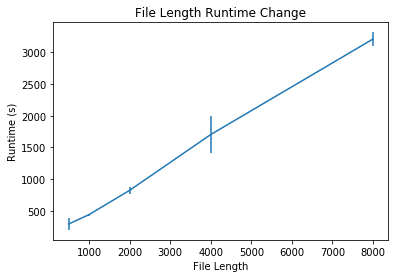

<Figure size 1440x720 with 0 Axes>

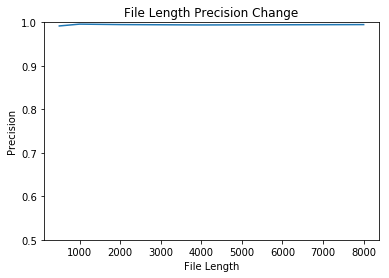

<Figure size 1440x720 with 0 Axes>

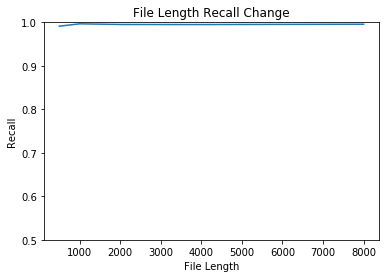

<Figure size 1440x720 with 0 Axes>

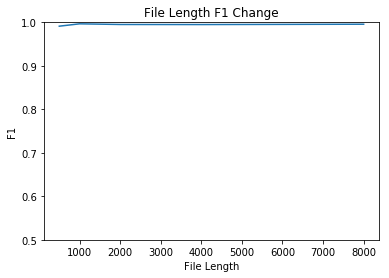

<Figure size 1440x720 with 0 Axes>

In [47]:
plt.errorbar(filelength, np.mean(runtimes, axis = 1), np.std(runtimes, axis = 1))
plt.title('File Length Runtime Change')
plt.xlabel('File Length')
plt.ylabel('Runtime (s)')
plt.figure(figsize = (20,10))
plt.show()
plt.errorbar(filelength, np.mean(precisionlist, axis = 1), np.std(precisionlist, axis = 1))
plt.title('File Length Precision Change')
plt.xlabel('File Length')
plt.ylabel('Precision')
plt.ylim(0.5,1)
plt.figure(figsize = (20,10))
plt.show()
plt.errorbar(filelength, np.mean(recalllist, axis = 1), np.std(recalllist, axis = 1))
plt.title('File Length Recall Change')
plt.xlabel('File Length')
plt.ylabel('Recall')
plt.ylim(0.5,1)
plt.figure(figsize = (20,10))
plt.show()
plt.errorbar(filelength, np.mean(F1list, axis = 1), np.std(F1list, axis = 1))
plt.title('File Length F1 Change')
plt.xlabel('File Length')
plt.ylabel('F1')
plt.ylim(0.5,1)
plt.figure(figsize = (20,10))
plt.show()
#Add AUC
#y axis 0.5

In [51]:
runtimes

[[502.80763125419617,
  229.36919498443604,
  442.5265109539032,
  228.8966579437256,
  246.4210569858551,
  255.94021129608154,
  256.0719449520111,
  265.1204810142517,
  231.05543327331543,
  240.58467292785645],
 [441.910325050354,
  425.74801206588745,
  423.9876070022583,
  422.8157801628113,
  431.3261139392853,
  460.7511250972748,
  448.85517287254333,
  463.4670889377594,
  428.5999960899353,
  430.61471605300903],
 [804.7152450084686,
  785.5491328239441,
  782.9860870838165,
  784.9419891834259,
  799.3319978713989,
  823.2679851055145,
  890.4111020565033,
  973.8661551475525,
  782.4456613063812,
  786.1919429302216],
 [1592.2992119789124,
  1572.3836691379547,
  1568.1352622509003,
  1564.8582918643951,
  1585.9804649353027,
  1543.8413679599762,
  2481.306386947632,
  1982.00790309906,
  1582.944354057312,
  1558.0299751758575],
 [3141.296996116638,
  3170.9199810028076,
  3110.833615064621,
  3188.0500700473785,
  3278.821671962738,
  3472.206141233444,
  3293.63235878

In [57]:
pd.DataFrame([runtimes, precisionlist, recalllist, F1list]).to_excel("trial_vals.xlsx")

In [25]:
# Data is split into Train/Validation/Test. Stratified sampling

X_train, X_val, X_test, y_train, y_val, y_test = Data_Splitter(Dataset, ttsplit)

In [34]:
# Counts and Percentages of each class in each data split

classcounts([y_train,y_val,y_test],5, filetype)

Filetype Location: ['fna', 'gbff', 'gff', 'fastq', 'sra']
Train counts: [7212, 7215, 7226, 10798, 6439]
Train percentages: [0.1854, 0.1855, 0.1858, 0.2777, 0.1656]
Validation counts: [1803, 1803, 1807, 2700, 1610]
Validation percentages: [0.1854, 0.1854, 0.1858, 0.2777, 0.1656]
Test counts: [2254, 2255, 2258, 3375, 2012]
Test percentages: [0.1855, 0.1855, 0.1858, 0.2777, 0.1655]


In [26]:
# Train and Validation Set are transformed via TF-IDF Vectorizer

dat_train, dat_val = Char_vectorizer2(X_train, y_train, X_val, y_val, filetype, ngram_range, max_features, load = True)

Loading Character Vectorizer...
Character Vectorizer Loaded
['aaaa', 'tttt', 'tatt', 'taaa', 'gaaa', 'aaat', 'aatt', 'attt', 'ttta', 'agaa', 'aaga', 'gaag', 'tion', 'ion ', ' gen', 'geno', 'enom', 'nome', ' :: ', 'atio', 'tion ', 'genom', 'enome', 'ation', '=gen', 'prot', 'rote', 'otei', 'tein', 'prote', 'rotei', 'otein', 'protei', 'rotein', 'protein', 'gene', 'gggg', 'ffff', 'hhhh', 'fffff', 'ggggg', 'ffffff', 'gggggg', 'fffffff', 'ggggggg', 'gggggggg', 'ffffffff', 'iiii', '\x01\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00\x00$', '\x00\x00$\x01', '\x00$\x01\x00', '$\x01\x00\x00', '\x00\x00\x00\x00\x00', '\x00\x00\x00\x00$', '\x00\x00$\x01\x00', '\x00\x00\x00\x00\x00\x00', '\x00\x00\x00\x00\x00\x00\x00', '\x00\x00\x00\x00\x00\x00\x00\x00']
Vectorizer Load Time: 297


In [27]:
# XGBoost Classifier Trained/Loaded

xgbmodel = TrainXGBClassifier(param, num_round, dat_train, dat_val, y_train, y_val, load = True)

Loading Model...
Model Loaded


In [28]:
# Linear SVM Trained/Loaded

svmmodel = TrainSVMClassifier(dat_train, y_train, load = True)

Loading Model...
Model Loaded


In [29]:
# MLP Trained/Loaded

mlpmodel = TrainMLPClassifier(FileNet, dat_train, y_train, dat_val, y_val, epochs = 50, load = True)

Loaders ready
Loading Model...
Model Loaded


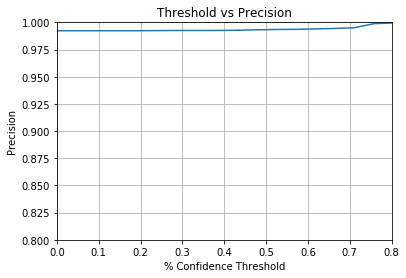

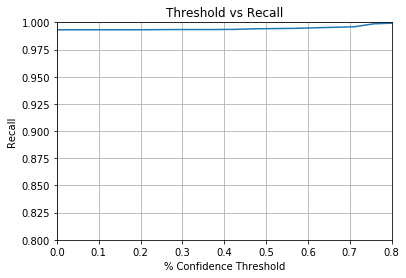

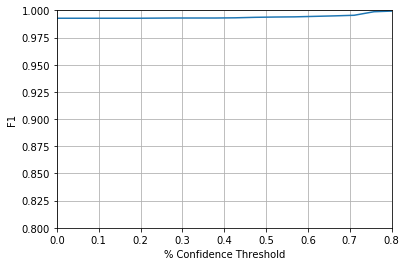

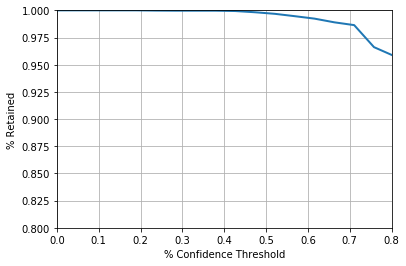

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3])

In [35]:
# XGB Diagnostics on Validation Set

TestFileClassifier(xgbmodel, dat_val, filetype, y_val, output = False, threshold = np.linspace(0, .9, 20), threshold_plots = True, classifier = 'xgb')

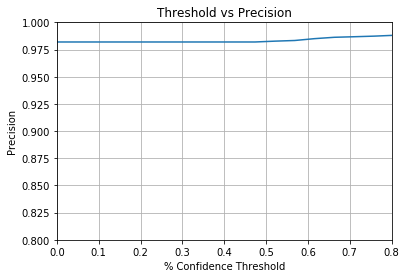

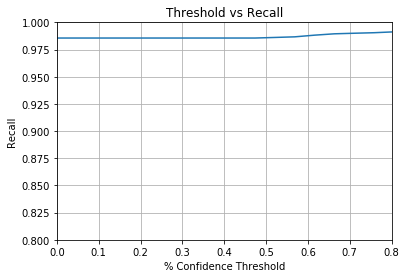

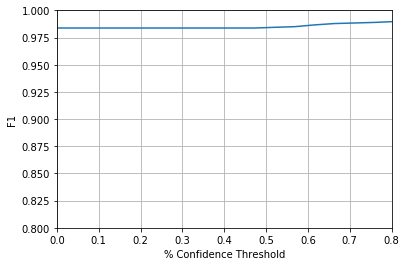

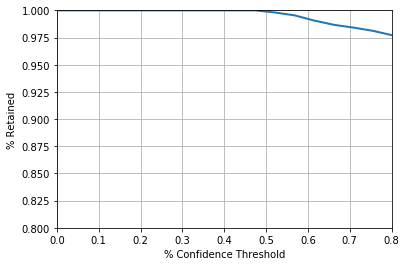

array([2, 4, 0, ..., 4, 3, 3])

In [36]:
# SVM Diagnostics on Validation Set

TestFileClassifier(svmmodel, dat_val, filetype, y_val, output = False, threshold = np.linspace(0, .9, 20), threshold_plots = True, classifier = 'svm')

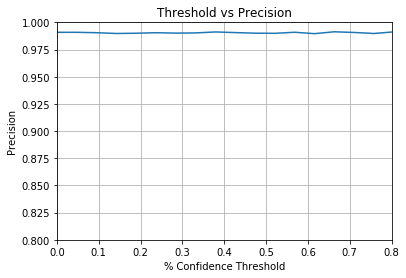

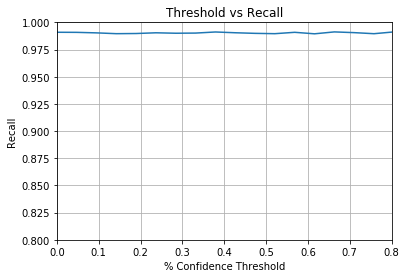

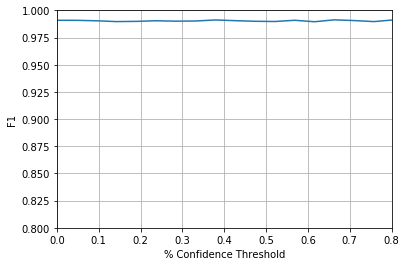

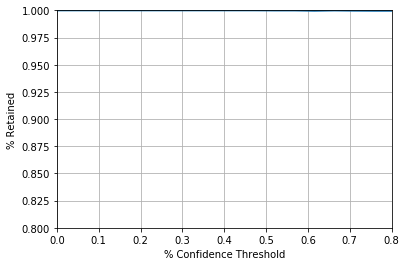

array([2, 4, 0, ..., 4, 3, 3])

In [37]:
# MLP Diagnostics on Validation Set

TestFileClassifier(mlpmodel, dat_val, filetype, y_val, output = False, threshold = np.linspace(0, .9, 20), threshold_plots = True, classifier = 'mlp')

In [31]:
# Test Set is transformed via TF-IDF Vectorizer

dat_test = test_char_vectorizer(X_test)

In [77]:
FileVecTime(X_test, test_char_vectorizer, 1000, 1, xgbmodel)

(0.00870511531829834, 0.0019447091400731946)

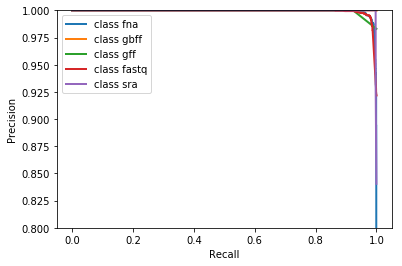

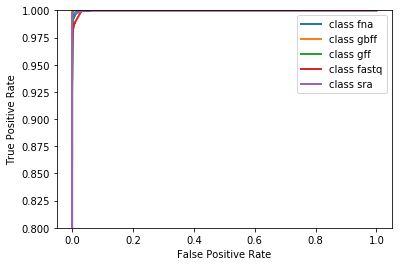

Testing time: 0
Precision: 0.9925608968837585
Recall: 0.9933447514721067
F1: 0.9929526694807503
Class fna mean and sd: [0.88798463, 0.052247345], Accuracy: 0.99
Class gbff mean and sd: [0.89857066, 0.015363637], Accuracy: 1.0
Class gff mean and sd: [0.8864151, 0.042855818], Accuracy: 1.0
Class fastq mean and sd: [0.88785976, 0.046232052], Accuracy: 0.98
Class sra mean and sd: [0.8996377, 0.00016745827], Accuracy: 1.0


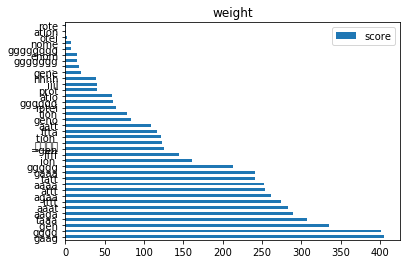

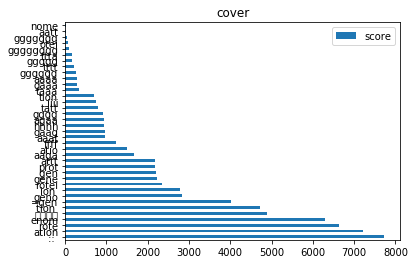

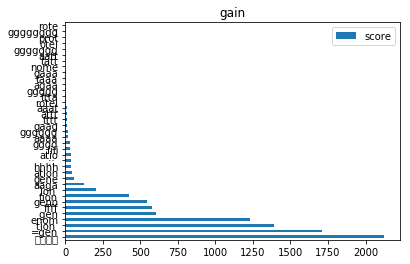

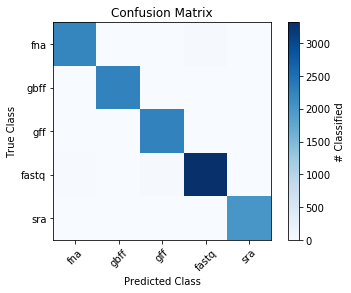

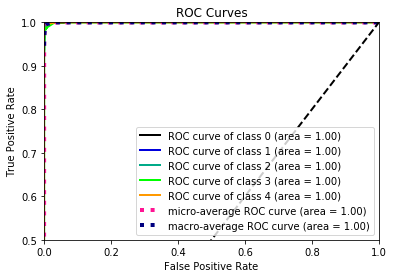

array([3, 3, 1, ..., 1, 2, 3])

In [58]:
# Test Set XGB Classifier

TestFileClassifier(xgbmodel, dat_test, filetype, y_test, output = True, threshold = np.linspace(0, .9, 20), threshold_plots = True, classifier = 'xgb')

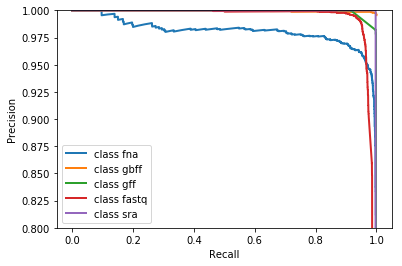

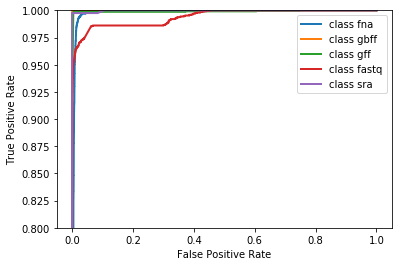

Testing time: 4
Precision: 0.9811686711233731
Recall: 0.9849035369069968
F1: 0.983032556530417
Class fna mean and sd: [0.9647461524251486, 0.07065486359376531], Accuracy: 0.99
Class gbff mean and sd: [0.9976782641330997, 0.020319036164055646], Accuracy: 1.0
Class gff mean and sd: [0.994775644650711, 0.01733611477788022], Accuracy: 1.0
Class fastq mean and sd: [0.9824371624695367, 0.06821149404286973], Accuracy: 0.95
Class sra mean and sd: [0.9581138656186711, 0.0004411389627084541], Accuracy: 1.0


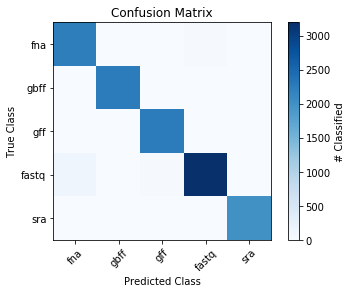

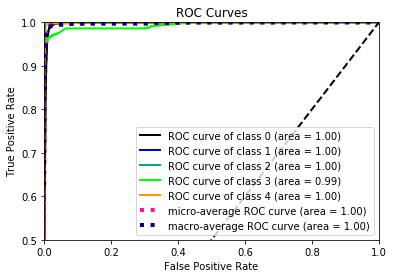

array([3, 3, 1, ..., 1, 2, 3])

In [59]:
# Test Set SVM Classifier

TestFileClassifier(svmmodel, dat_test, filetype, y_test, output = True, threshold = np.linspace(0, .9, 20), threshold_plots = True, classifier = 'svm')

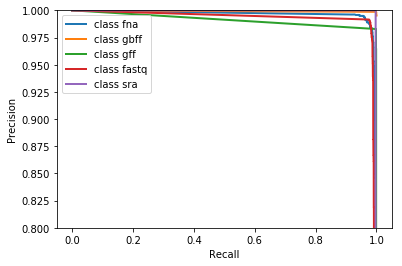

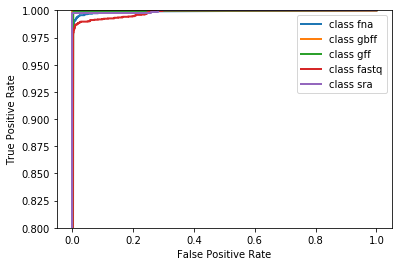

Testing time: 0
Precision: 0.99061457112874
Recall: 0.9905654393786512
F1: 0.9905900046444807
Class fna mean and sd: [0.99841785, 0.021383189], Accuracy: 0.98
Class gbff mean and sd: [0.99991316, 0.004004893], Accuracy: 1.0
Class gff mean and sd: [0.9998788, 0.0046674614], Accuracy: 1.0
Class fastq mean and sd: [0.99987733, 0.0059500854], Accuracy: 0.98
Class sra mean and sd: [1.0, 2.6609481e-09], Accuracy: 1.0


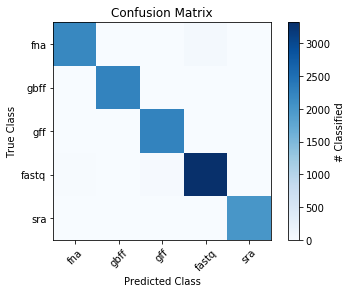

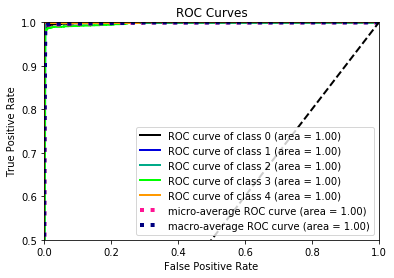

array([3, 3, 1, ..., 1, 2, 3])

In [60]:
# Test Set MLP Classifier

TestFileClassifier(mlpmodel, dat_test, filetype, y_test, output = True, threshold = np.linspace(0, .9, 20), threshold_plots = True, classifier = 'mlp')